<a href="https://colab.research.google.com/github/sravyagadam/ML_RecommenderSystems/blob/main/NETFLIX_MOVIES_AND_TV_SHOWS_CLUSTERING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Problem Statement**

This dataset consists of tv shows and movies available on Netflix as of 2019. The dataset is collected from Flixable which is a third-party Netflix search engine.

In 2018, they released an interesting report which shows that the number of TV shows on Netflix has nearly tripled since 2010. The streaming service’s number of movies has decreased by more than 2,000 titles since 2010, while its number of TV shows has nearly tripled. It will be interesting to explore what all other insights can be obtained from the same dataset.

Integrating this dataset with other external datasets such as IMDB ratings, rotten tomatoes can also provide many interesting findings.

## <b>In this  project, you are required to do </b>
1. Exploratory Data Analysis 

2. Understanding what type content is available in different countries

3. Is Netflix has increasingly focusing on TV rather than movies in recent years.
4. Clustering similar content by matching text-based features



# **Attribute Information**

1. show_id : Unique ID for every Movie / Tv Show

2. type : Identifier - A Movie or TV Show

3. title : Title of the Movie / Tv Show

4. director : Director of the Movie

5. cast : Actors involved in the movie / show

6. country : Country where the movie / show was produced

7. date_added : Date it was added on Netflix

8. release_year : Actual Releaseyear of the movie / show

9. rating : TV Rating of the movie / show

10. duration : Total Duration - in minutes or number of seasons

11. listed_in : Genere

12. description: The Summary description

In [1]:
import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt

import warnings
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MinMaxScaler

from time import time
import keras.backend as K

from tensorflow.keras.layers import Layer, InputSpec
from keras.layers import Dense, Input, Embedding
from keras.models import Model
from tensorflow.keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:


netflix = pd.read_csv("/content/drive/MyDrive/Book_Recommendation/NETFLIX MOVIES AND TV SHOWS CLUSTERING.csv")


In [4]:
netflix.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [5]:
print(f"Shape of data {netflix.shape}")
print(f"data types in data \n {netflix.dtypes}")

Shape of data (7787, 12)
data types in data 
 show_id         object
type            object
title           object
director        object
cast            object
country         object
date_added      object
release_year     int64
rating          object
duration        object
listed_in       object
description     object
dtype: object


#dropping duplicates if any 

In [46]:
netflix_d = netflix.drop_duplicates("title")
print(f"shape after dropping duplicates in data set{netflix_d.shape}")

shape after dropping duplicates in data set(7787, 13)


In [6]:
netflix_copy=netflix.copy()

#Removing unwanted columns

In [7]:
netflix.drop(columns=['show_id','cast', 'date_added','duration'])

,type,title,director,country,release_year,rating,listed_in,description
0,TV Show,3%,NaN,Brazil,2020,TV-MA,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,Movie,7:19,Jorge Michel Grau,Mexico,2016,TV-MA,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,Movie,23:59,Gilbert Chan,Singapore,2011,R,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,Movie,9,Shane Acker,United States,2009,PG-13,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,Movie,21,Robert Luketic,United States,2008,PG-13,Dramas,A brilliant group of students become card-coun...
...,...,...,...,...,...,...,...,...
7782,Movie,Zozo,Josef Fares,"Sweden, Czech Republic, United Kingdom, Denmar...",2005,TV-MA,"Dramas, International Movies",When Lebanon's Civil War deprives Zozo of his ...
7783,Movie,Zubaan,Mozez Singh,India,2015,TV-14,"Dramas, International Movies, Music & Musicals",A scrappy but poor boy worms his way into a ty...
7784,Movie,Zulu Man in Japan,NaN,NaN,2019,TV-MA,"Documentaries, International Movies, Music & M...","In this documentary, South African rapper Nast..."
7785,TV Show,Zumbo's Just Desserts,NaN,Australia,2019,TV-PG,"International TV Shows, Reality TV",Dessert wizard Adriano Zumbo looks for the nex...


#Selecting the columns for clustering

In [59]:
x = netflix[['type','director','country','release_year','rating']]
x.head()
print(x.dtypes)


type            object
director        object
country         object
release_year     int64
rating          object
dtype: object


In [ ]:
x(type).unique

In [64]:
from sklearn import preprocessing
 
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
 
# Encode labels 
for column in x:
  print(x[column].dtypes)
  if x[column].dtypes!='int64':
    print (x[column])
    x[column]= label_encoder.fit_transform(x[column])
 
x.head()

object
0       TV Show
1         Movie
2         Movie
3         Movie
4         Movie
         ...   
7782      Movie
7783      Movie
7784      Movie
7785    TV Show
7786      Movie
Name: type, Length: 7787, dtype: object
object
0                     NaN
1       Jorge Michel Grau
2            Gilbert Chan
3             Shane Acker
4          Robert Luketic
              ...        
7782          Josef Fares
7783          Mozez Singh
7784                  NaN
7785                  NaN
7786             Sam Dunn
Name: director, Length: 7787, dtype: object
object
0                                                  Brazil
1                                                  Mexico
2                                               Singapore
3                                           United States
4                                           United States
                              ...                        
7782    Sweden, Czech Republic, United Kingdom, Denmar...
7783                       

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,type,director,country,release_year,rating
0,1,4049,39,2020,8
1,0,1840,308,2016,8
2,0,1289,379,2011,5
3,0,3445,549,2009,4
4,0,3176,549,2008,4


In [10]:
from sklearn import preprocessing

# scale the data for better results
x_scaled = preprocessing.scale(x)

In [11]:
from sklearn.manifold import TSNE

X_tsne = TSNE(learning_rate=100).fit_transform(x_scaled)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


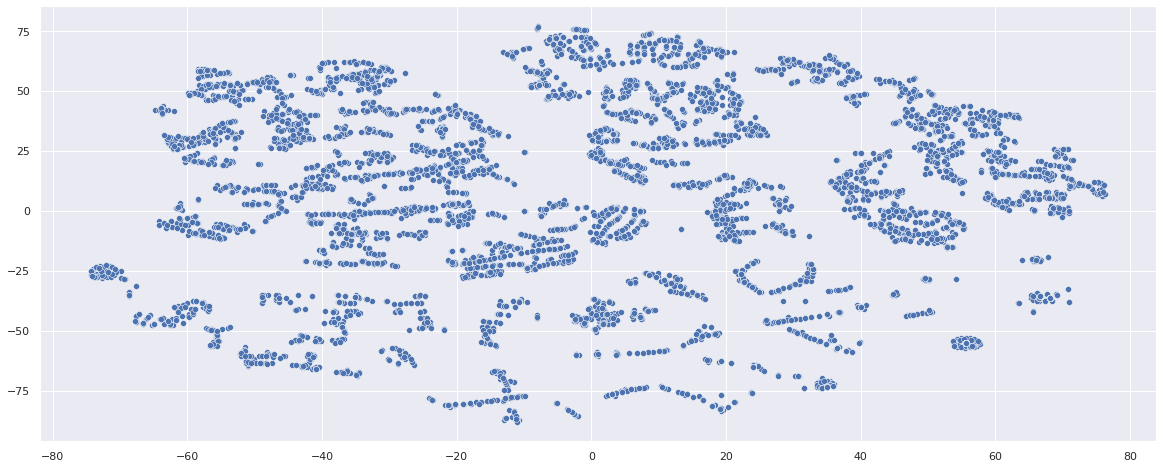

In [12]:
from matplotlib import rcParams
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

rcParams['figure.figsize'] = 20,8
sns.scatterplot(X_tsne[:, 0], X_tsne[:, 1])

In [13]:
data = pd.DataFrame({'d1': X_tsne[:, 0], 'd2': X_tsne[:, 1]})

#K-Means

In [14]:
from sklearn.cluster import KMeans
wcss = []

for i in range(1,11):
    kmeans = KMeans(i)
    kmeans.fit(x_scaled)
    wcss.append(kmeans.inertia_)
    
wcss

[38934.999999999985,
 27269.603946954907,
 22236.78161712952,
 18246.7673524326,
 15404.529857927097,
 13657.331572606523,
 12167.184570236943,
 11160.7346364205,
 10482.321971243076,
 9853.261094544598]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'WCSS')

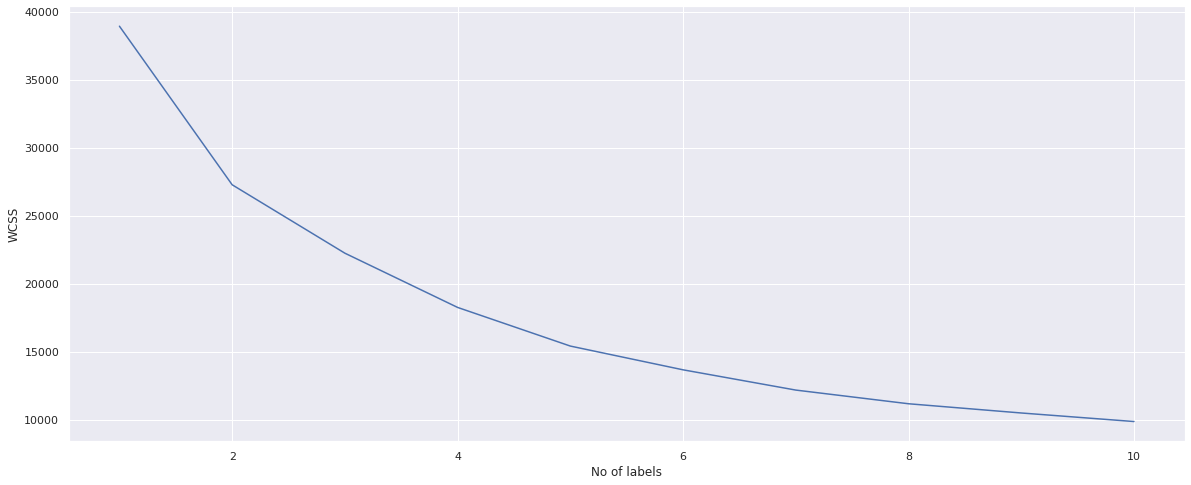

In [15]:
sns.lineplot(range(1,11), wcss)
plt.xlabel('No of labels')
plt.ylabel('WCSS')

In [16]:
kmeans_model = KMeans(6)
kmeans_model.fit(x_scaled)
data['kmeans']=kmeans_model.fit_predict(x_scaled)

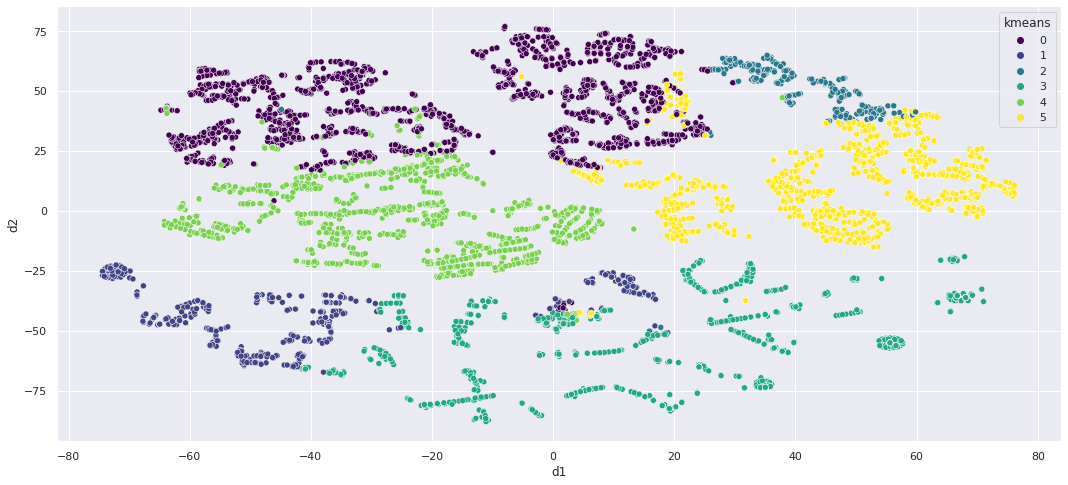

In [17]:
rcParams['figure.figsize'] = 18,8
sns.scatterplot(data=data, x='d1', y='d2', hue='kmeans', palette='viridis')

#DBSCAN

In [18]:
from sklearn.cluster import DBSCAN
model_dbscan = DBSCAN(eps=0.30, min_samples=9)
data['dbscan'] = model_dbscan.fit_predict(x)

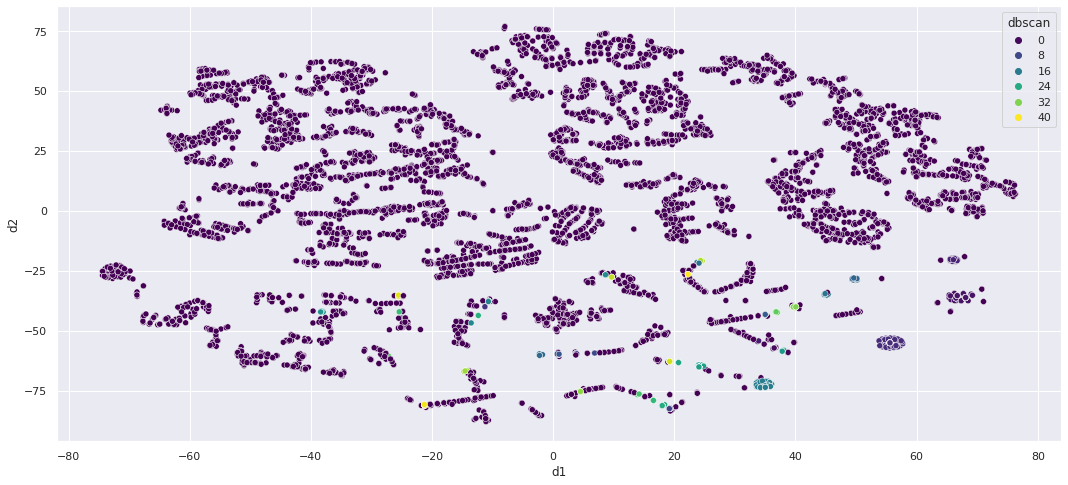

In [19]:
rcParams['figure.figsize'] = 18,8
sns.scatterplot(data=data, x='d1', y='d2', hue='dbscan', palette='viridis')

#BIRCH

In [20]:
from sklearn.cluster import Birch

In [21]:
model_birch = Birch(threshold=0.01, n_clusters=8)
model_birch.fit(x_scaled)
data['birch'] = model_birch.predict(x)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but Birch was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


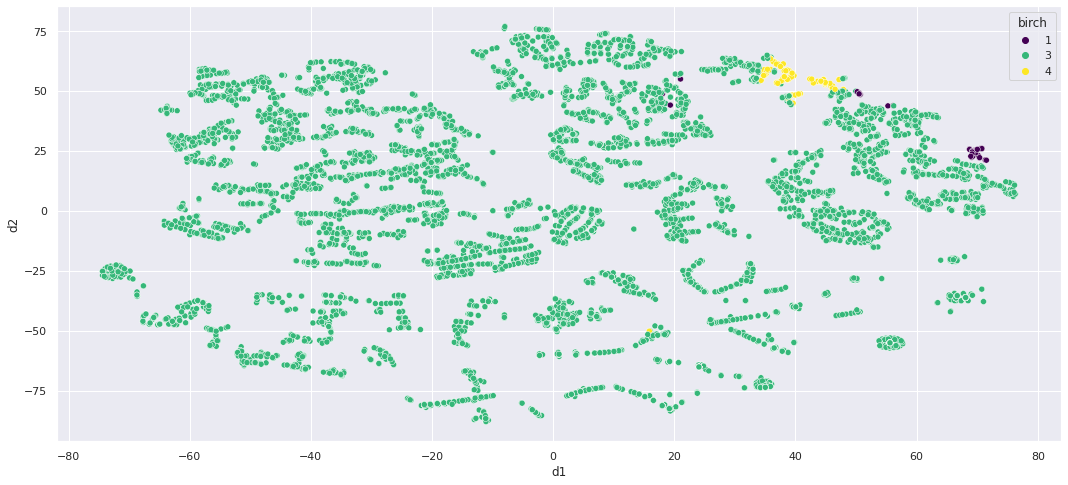

In [22]:
rcParams['figure.figsize'] = 18,8
sns.scatterplot(data=data, x='d1', y='d2', hue='birch', palette='viridis')

#Agglomerative Clustering

In [23]:
from sklearn.cluster import AgglomerativeClustering

In [24]:
model_agg = AgglomerativeClustering(n_clusters=6)
model_agg.fit(x_scaled)
data['agg']=model_agg.fit_predict(x_scaled)

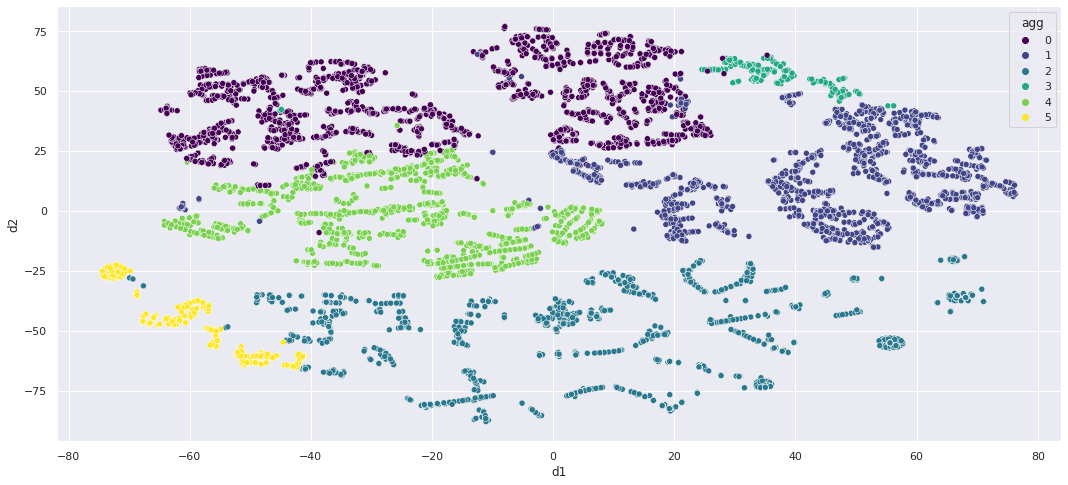

In [25]:
rcParams['figure.figsize'] = 18,8
sns.scatterplot(data=data, x='d1', y='d2', hue='agg', palette='viridis')

#Affinity Propagation Clustering

In [26]:
from sklearn.cluster import AffinityPropagation

In [27]:
model_ap = AffinityPropagation(damping=0.9)
model_ap.fit(x_scaled)
data['ap'] = model_ap.predict(x_scaled)

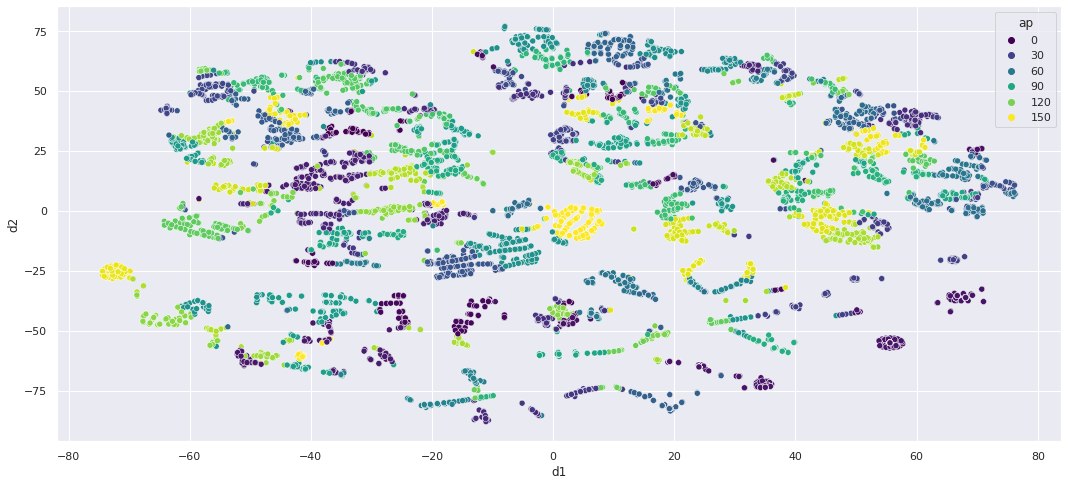

In [28]:
rcParams['figure.figsize'] = 18,8
sns.scatterplot(data=data, x='d1', y='d2', hue='ap', palette='viridis')

#Mini-Batch Kmeans

In [29]:
from sklearn.cluster import MiniBatchKMeans

In [30]:
model_minibatch_kmeans = MiniBatchKMeans(n_clusters=6)
model_minibatch_kmeans.fit(x_scaled)
data['minibatch_kmeans'] = model_minibatch_kmeans.predict(x)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but MiniBatchKMeans was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


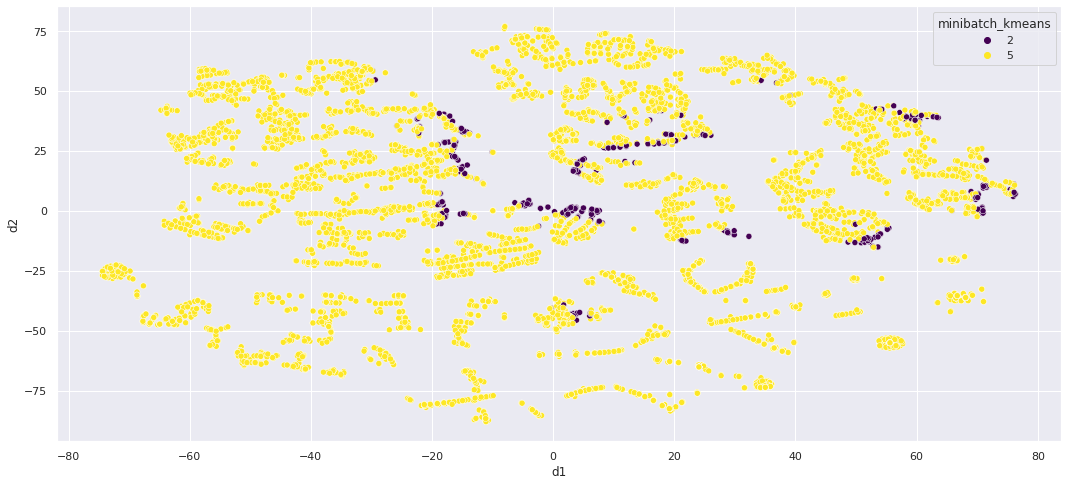

In [31]:
rcParams['figure.figsize'] = 18,8
sns.scatterplot(data=data, x='d1', y='d2', hue='minibatch_kmeans', palette='viridis')

In [32]:
x= x.join(data['agg'])
x.head(3)

,type,director,country,release_year,rating,agg
0,1,4049,39,71,8,5
1,0,1840,308,67,8,4
2,0,1289,379,62,5,1


In [33]:
average = x.groupby('agg').mean().reset_index()
average

,agg,type,director,country,release_year,rating
0,0,0.00000,2186.760311,198.403688,65.812712,7.016012
1,1,0.00000,1989.001232,537.321429,62.683498,4.737069
2,2,1.00000,3870.856657,479.694849,67.284257,7.810010
3,3,0.03211,2474.256881,323.733945,28.784404,5.935780
4,4,0.00000,2145.317353,528.886563,67.667117,8.428764
5,5,1.00000,4041.414493,93.913043,67.794203,8.394203


In [36]:
netflix = netflix.join(data['agg'])

In [ ]:
print(f"null data sum \n {netflix.isna().sum()}")

null data sum 
 show_id            0
type               0
title              0
director        2389
cast             718
country          507
date_added        10
release_year       0
rating             7
duration           0
listed_in          0
description        0
dtype: int64


#cluster -0

In [40]:
cluster_0 = netflix.loc[ netflix['agg'] == 0, ['type', 'title']]
cluster_0.sample(15)

,type,title
406,Movie,All Because of You
6637,Movie,The Man Who Feels No Pain
5457,Movie,Secret
4921,Movie,Potato Potahto
2762,Movie,Ho Mann Jahaan
5984,Movie,Tarek's Situation
2326,Movie,Gabbar Is Back
3232,Movie,Judge Singh LLB
2267,Movie,Freaks – You're One of Us
5566,Movie,Shimmer Lake


#cluster -1

In [41]:
cluster_1 = netflix.loc[ netflix['agg'] == 1, ['type', 'title']]
cluster_1.sample(15)

,type,title
3324,Movie,Katt Williams: Live
4844,Movie,Philadelphia
6753,Movie,The Phantom of the Opera
1852,Movie,Dragonheart: Battle for the Heartfire
7215,Movie,Trevor Noah: Afraid of the Dark
4129,Movie,Misfit
3262,Movie,K-19: The Widowmaker
467,Movie,American Honey
1333,Movie,Children of God
5937,Movie,Sweeney Todd: The Demon Barber of Fleet Street


#cluster -2

In [42]:
cluster_2 = netflix.loc[ netflix['agg'] == 2, ['type', 'title']]
cluster_2.sample(15)

,type,title
6770,TV Show,The Politician
531,TV Show,Anitta: Made In Honório
4552,TV Show,Nurse Jackie
5331,TV Show,Sacred Games
2090,TV Show,Fairy Tail
1742,TV Show,Diablero
7520,TV Show,Weeds
5525,TV Show,"Sex, Explained"
6996,TV Show,The West Wing
4055,TV Show,Metallica: Some Kind of Monster


#cluster -3

In [43]:
cluster_3 = netflix.loc[ netflix['agg'] == 3, ['type', 'title']]
cluster_3.sample(15)

,type,title
3704,Movie,Logan's Run
408,Movie,All Dogs Go to Heaven
6850,Movie,The School of Mischief
3187,Movie,Jis Desh Men Ganga Behti Hai
5122,Movie,Rebel Without a Cause
1259,Movie,Chadi Jawani Budhe Nu
5846,Movie,Strictly Ballroom
4003,Movie,Maza Pati Karodpati
4867,TV Show,Pioneers: First Women Filmmakers*
5693,Movie,Sohni Mahiwal


#cluster -4

In [44]:
cluster_4 = netflix.loc[ netflix['agg'] == 4, ['type', 'title']]
cluster_4.sample(15)

,type,title
5019,Movie,Q Ball
4416,Movie,Natalia Valdebenito: Gritona
5845,Movie,Stretch Armstrong: The Breakout
7078,Movie,Tiffany Haddish: Black Mitzvah
6131,Movie,The Bill Murray Stories: Life Lessons Learned ...
5979,Movie,Tanda Tanya
7201,Movie,Travis Scott: Look Mom I Can Fly
848,Movie,Bert Kreischer: The Machine
7784,Movie,Zulu Man in Japan
6346,Movie,The Feels


#cluster -5

In [45]:
cluster_5 = netflix.loc[ netflix['agg'] == 5, ['type', 'title']]
cluster_5.sample(15)

,type,title
3573,TV Show,Legend Quest: Masters of Myth
5635,TV Show,Sintonia
6586,TV Show,The Legend of White Snake
7076,TV Show,Tientsin Mystic
5631,TV Show,Singles Villa
2044,TV Show,Ever After High
1201,TV Show,Cannabis
7160,TV Show,Total Drama
2749,TV Show,Historia de un clan
7073,TV Show,Tidelands


shape after dropping duplicates in data set(7787, 12)
